# Using RAG to prevent Hallucination

Although there have been a great use of LLMs in using various tools and help in completing different tasks, there are some limitations that prevent LLMs from being deployed in sensitive fields like medicine. For example, LLMs crystalline their knowledge at the time of training and rapidly developing fields such as medical sciences cause this knowledge to be outdated in very short time. Another problem that is always concerned with LLMs is that they often hallucinate - produce contents that are factually or conceptually wrong. To overcome these, there is a new paradigm that has emerged: **retrieval-augmented generation (RAG)**. It allows for the LLM to refer to memory that is external to the model and allows knowledge to be found and keep updated. Also, providing contextual guidance to the model's response allows for reduction of hallucinations. Hence, RAG is widely used today and is considered a promising system. 

## Information Retrieval 
It is the scientific field that deals with finding information in media (often textual but also multimodal). 

Example: A user might want to find a whole document or a piece of text in documents; this task is key to question answering, where a model has to find the steps needed to answer the user's question. 

Central to this system is a **search engine**, in the case of RAG it is a Transformer.

A system that has a collection of documents (textual, but could also be web pages, images, videos, etc) that have corresponding index in the database. These documents can be associated with a metadata (attributes that describe author, size, topic, and keywords). We also have a convention where a **term** is defined as a word present in the text but also a passage that can answer the search. A user writes a **query** that can be expressed as terms. The purpose of this retrieval system is to best match the query with relevant document in the collection. These are then returned in order of relevance. 

## Implementation of TF-IDF for information retrieval and a need of modern solution using transformers

we can take a set of document and calculate the TF-IDF, and once we calculate it, we calculate a score (usually cosine-similarity) between each of the document and conduct rank based on the score. For a document **d** and a query **q** in vector form, we use the following formula:

$\cos(\mathbf{q}, \mathbf{d}) = \frac{\mathbf{q} \cdot \mathbf{d}}{\|\mathbf{q}\| \|\mathbf{d}\|}$

But for TF-IDF and also a variant of it like BM25 there are the following disadvantages 

- It is not always easy to find the optimal parameters for a precise dataset.
- The model is sensitive to choice of hyperparameters.
- Being based on term frequency, BM25 does not capture the context of a term.
- It faces problems with mismatches in vocabularies, where there is no complete overlap between terms in the query and documents.


**Possible Solution**\
To use dense vector that includes contextual information.  This is done by using transformers and extracting the representation of the document. Given a sequence of token, we use the representation *z* obtained from the final layer. This allows us to obtain a big high-dimensional representation that we can use to disambiguate the meaning of a word. This is called **z-score**.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
sentences = [
    "I need to go to the bank to deposit my money", 
    "My brother has gone to the bank of river for fishing", 
    "The company directly deposits my salary into my bank account",
    "The picnic is set on the bank of Godawari river", 
    "I tried withdrawing the money from my bank yesterday", 
    "There were many fisherman along the bank of the river after the flood last week", 
    "I have an appointment with the manager of the bank tomorrow",
    "It is risky to go to the river bank today, the water level is too high",
    "This bank offers loan in the minimal interest rate",
    "The erosion has brought a lot of sand to the river bank"
]

In [5]:
labels = ["money", "river","money", "river","money", "river","money", "river","money", "river"]

In [6]:
def get_word_embedding(text, word, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    tokenized_text = tokenizer.tokenize(text)
    word_index = tokenized_text.index(word)
    with torch.no_grad():
        outputs = model(**inputs)
    word_embedding = outputs.last_hidden_state[0, word_index, :].numpy()
    return word_embedding

In [7]:
model_used = "bert-base-uncased"
tokenizer  = BertTokenizer.from_pretrained(model_used)
model = BertModel.from_pretrained(model_used)

In [8]:
embeddings = np.array([get_word_embedding(sentence, "bank", model, tokenizer) for sentence in sentences])
embeddings

array([[ 0.38549128, -0.5164612 , -0.28320944, ..., -0.11805634,
         0.4499613 , -0.05410718],
       [ 0.3064443 , -0.50458634, -0.43764374, ..., -0.98827606,
         0.13129072, -0.4941981 ],
       [ 0.73640394,  0.4615822 ,  0.9363466 , ..., -0.16595432,
        -0.06706684,  0.45113388],
       ...,
       [ 0.5974556 ,  0.12453198, -0.2921982 , ..., -0.37521163,
        -0.37006932,  0.10434859],
       [-0.06798005, -0.28045896, -0.28684345, ..., -0.60608566,
         0.8571196 , -0.00506158],
       [ 0.3361669 ,  0.41064253, -0.3960354 , ..., -0.18413724,
        -0.5679618 , -0.28876424]], shape=(10, 768), dtype=float32)

In [9]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
embeddings_2d

array([[-22.818417 ,  49.807117 ],
       [ 35.92617  ,  49.11506  ],
       [-99.34352  ,  -2.1433756],
       [ 70.12161  ,  46.865025 ],
       [-72.76807  ,  -8.111011 ],
       [ 27.318644 ,  22.575602 ],
       [-25.240057 ,  21.603369 ],
       [ 25.642103 , -41.959724 ],
       [-40.532417 , -33.71208  ],
       [ 52.80442  , -41.290665 ]], dtype=float32)

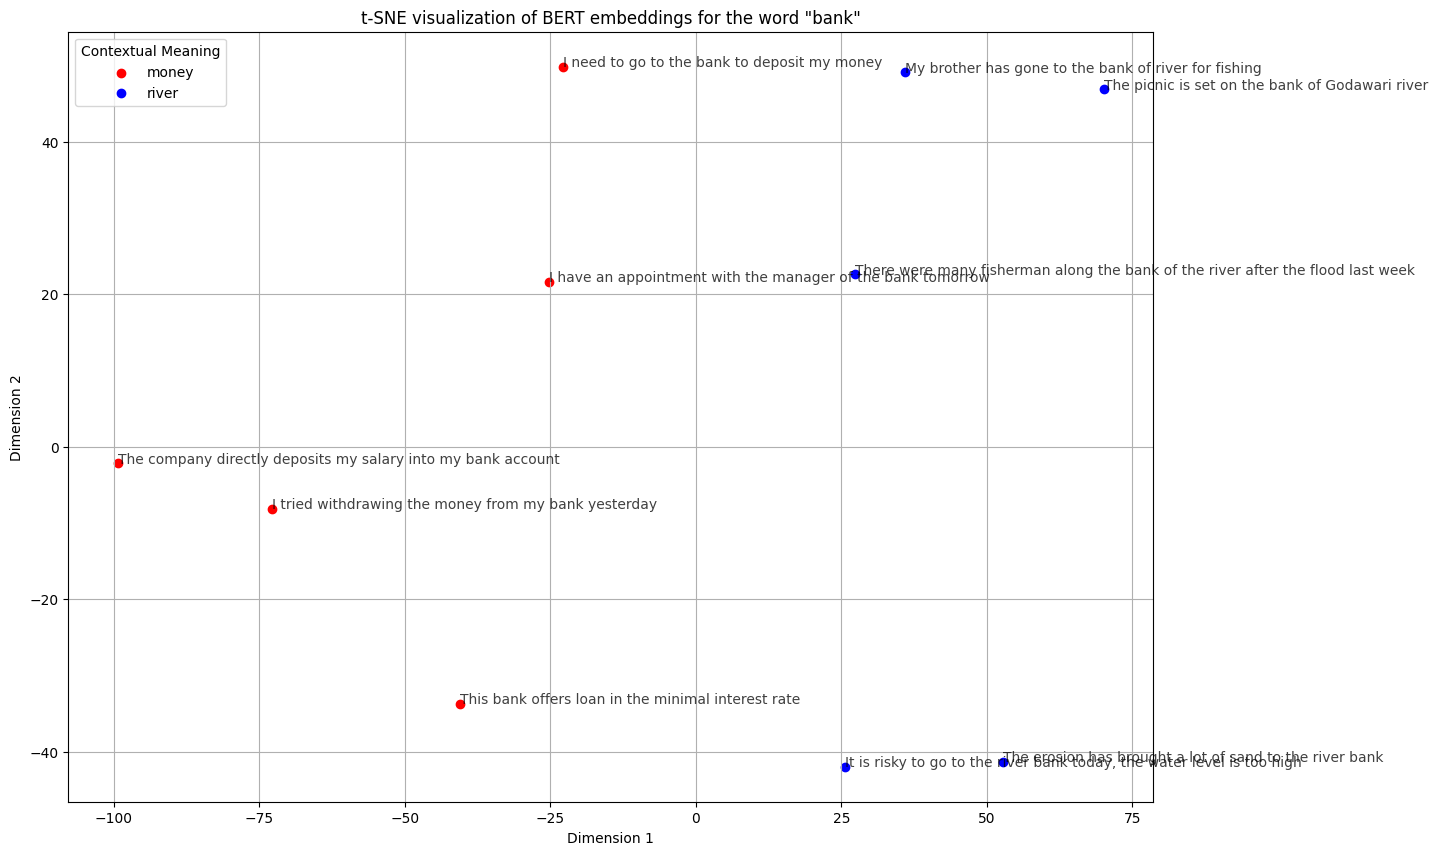

In [10]:
plt.figure(figsize=(14, 10))
colors = {'money': 'red', 'river': 'blue'}
for i, label in enumerate(labels ):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[label], label=label if (labels + ['money', 'river']).index(label) == i else "")
    plt.annotate(sentences[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10, alpha=0.75)

plt.title('t-SNE visualization of BERT embeddings for the word "bank"')
plt.xlabel('Dimension 1', fontsize=10)
plt.ylabel('Dimension 2', fontsize=10)
plt.legend(title="Contextual Meaning", loc= 'upper left')
plt.grid(True)
plt.show()

The figure above shows the *t-distributed stochastic neighbor embedding (t-SNE) visualization* of the contextual embedding of the word "bank" that could be used in both financial institution, and river-related context. The t-SNE is conducted on the BERT embedding of the word for each sentence.

There are various ways to retrieve the representation from the model. We used the last layer for convenience, but it is suggested to conduct an average pool of the representation of multiple layer as each block learns a different text representation because of self attention. As we know, the vectors have geometric properties and can be used for various operations like clustering, similarity computation, etc.

## Embeddings retrieval 

**Using Single Encoder**\
\
Models are provided with both query and document allowing bidirectional self attention mechanism to take all the tokens into account. The representation will be representing both the query and the document. The format used is *[CLS]-query-[SEP]-document*. The representation for the [CLS] token is then fed to the linear layer to produce the similarity score - this is the fine tuned layer. Usually, this is not done for the whole document but for the series of chunks because documents are usually longer than the context length. For example, for BERT the context length is 512, so the sum of query and document must be no more than 512 tokens.

In [11]:
# we now use the CLS embeddings for the same text
def get_cls_embeddings(text, model, tokenizer):
    inputs  = tokenizer(text, return_tensors = "pt")
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].squeeze().numpy()
    return cls_embedding

In [12]:
cls_embeddings = np.array([get_cls_embeddings(sentence, model, tokenizer) for sentence in sentences])

In [13]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_cls_2d = tsne.fit_transform(cls_embeddings)

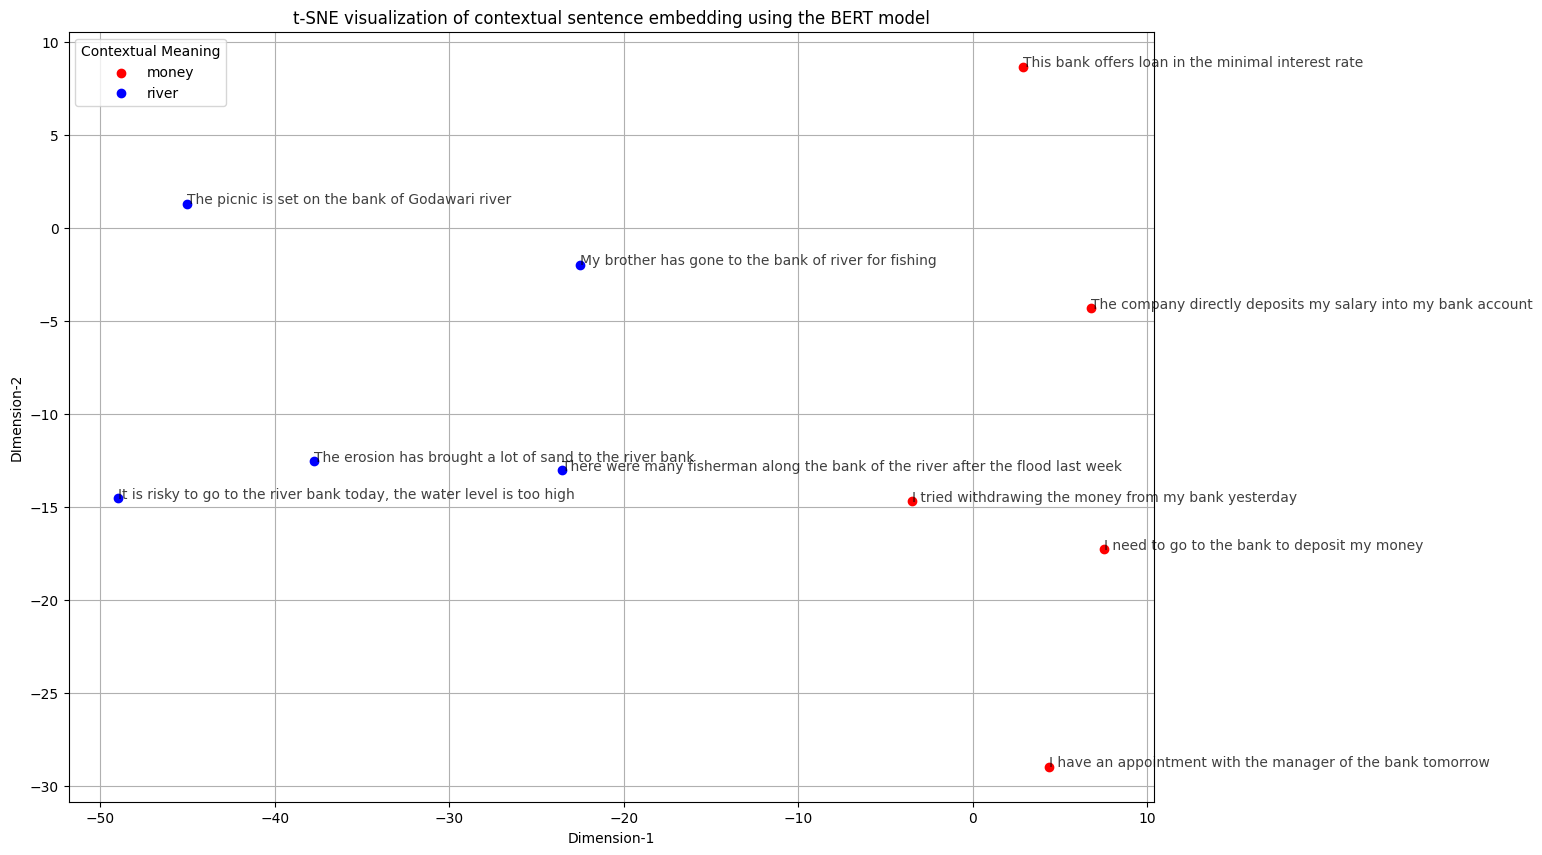

In [18]:
plt.figure(figsize=(14, 10))
colors = {'money':'red', 'river':'blue'}
for i, label in enumerate(labels ):
    plt.scatter(embeddings_cls_2d[i, 0], embeddings_cls_2d[i, 1], color=colors[label], label=label if (labels + ['money', 'river']).index(label) == i else "")
    plt.annotate(sentences[i], (embeddings_cls_2d[i, 0], embeddings_cls_2d[i, 1]), fontsize=10, alpha=0.75)

plt.title("t-SNE visualization of contextual sentence embedding using the BERT model")
plt.xlabel("Dimension-1", fontsize=10)
plt.ylabel("DImension-2", fontsize=10)
plt.legend(title="Contextual Meaning")
plt.grid(True)
plt.show()


**Using bi-encoder**\
\
In a bi-encoder, one encoder is used to extract representation of the query i.e. [CLS]q and another to extract the representation for each document or chunk of documents i.e. [CLS]d. We compute the embeddings for each document in the corpus and store it's representation in the database. Following it, we calculate the cosine similarity between the representation for the query and all the vectors in the database. This system is much faster but less accurate because part of interactions there are between the terms in the query and in the document. 

In [19]:
queries = [
    "I am going to the nearest bank to open my account", 
    "Santiago-the fisherman waited all day by the river bank"
]

In [22]:
def get_primary_cls_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs)
    primary_cls_embeddings = outputs.last_hidden_state[:,0,:].squeeze().numpy()
    return primary_cls_embeddings

In [29]:
primary_cls_embeddings = np.array([get_primary_cls_embeddings(sentence, model, tokenizer) for sentence in sentences])
new_embeddings = np.array([get_primary_cls_embeddings(sentence, model, tokenizer) for sentence in queries])

In [27]:
new_embeddings

array([[ 0.23072109,  0.2575392 ,  0.17903642, ...,  0.10229553,
         0.07124981,  0.58120626],
       [-0.28369862, -0.22283682,  0.11080316, ..., -0.32067898,
         0.44915202,  0.27642405]], shape=(2, 768), dtype=float32)

In [30]:
primary_cls_embeddings

array([[ 0.30758294,  0.4403467 ,  0.08301728, ...,  0.0875296 ,
        -0.02781028,  0.24192682],
       [ 0.09822543,  0.15743588, -0.02193351, ..., -0.33942804,
         0.29809457,  0.27442288],
       [ 0.27424613,  0.41309682,  0.1676368 , ..., -0.09938911,
         0.02078443,  0.5784815 ],
       ...,
       [-0.10976194,  0.03201431, -0.02197827, ..., -0.36888406,
         0.29295987,  0.33560875],
       [ 0.02047934,  0.1280429 ,  0.11502129, ..., -0.45006078,
        -0.00953573,  0.16052398],
       [-0.24075408, -0.04383044,  0.170375  , ..., -0.4363308 ,
         0.05632936,  0.47184044]], shape=(10, 768), dtype=float32)

In [ ]:
similarities = cosine_similarity(primary_cls_embeddings, new_embeddings)
similarities

array([[0.96349764, 0.70803297],
       [0.8684291 , 0.80358446],
       [0.92825085, 0.6880484 ],
       [0.8297952 , 0.74715555],
       [0.9325427 , 0.71132696],
       [0.8686292 , 0.755428  ],
       [0.92839044, 0.7286705 ],
       [0.8111469 , 0.76336104],
       [0.86464435, 0.70754546],
       [0.8417348 , 0.7107573 ]], dtype=float32)

In [34]:
sorted_indices = sorted(range(len(labels)), key=lambda i: labels[i])
sorted_indices

[0, 2, 4, 6, 8, 1, 3, 5, 7, 9]

In [36]:
sorted_sentences = [sentences[i] for i in sorted_indices]
sorted_sentences

['I need to go to the bank to deposit my money',
 'The company directly deposits my salary into my bank account',
 'I tried withdrawing the money from my bank yesterday',
 'I have an appointment with the manager of the bank tomorrow',
 'This bank offers loan in the minimal interest rate',
 'My brother has gone to the bank of river for fishing',
 'The picnic is set on the bank of Godawari river',
 'There were many fisherman along the bank of the river after the flood last week',
 'It is risky to go to the river bank today, the water level is too high',
 'The erosion has brought a lot of sand to the river bank']

In [39]:
sorted_similarities = similarities[sorted_indices, :]
sorted_similarities

array([[0.96349764, 0.70803297],
       [0.92825085, 0.6880484 ],
       [0.9325427 , 0.71132696],
       [0.92839044, 0.7286705 ],
       [0.86464435, 0.70754546],
       [0.8684291 , 0.80358446],
       [0.8297952 , 0.74715555],
       [0.8686292 , 0.755428  ],
       [0.8111469 , 0.76336104],
       [0.8417348 , 0.7107573 ]], dtype=float32)

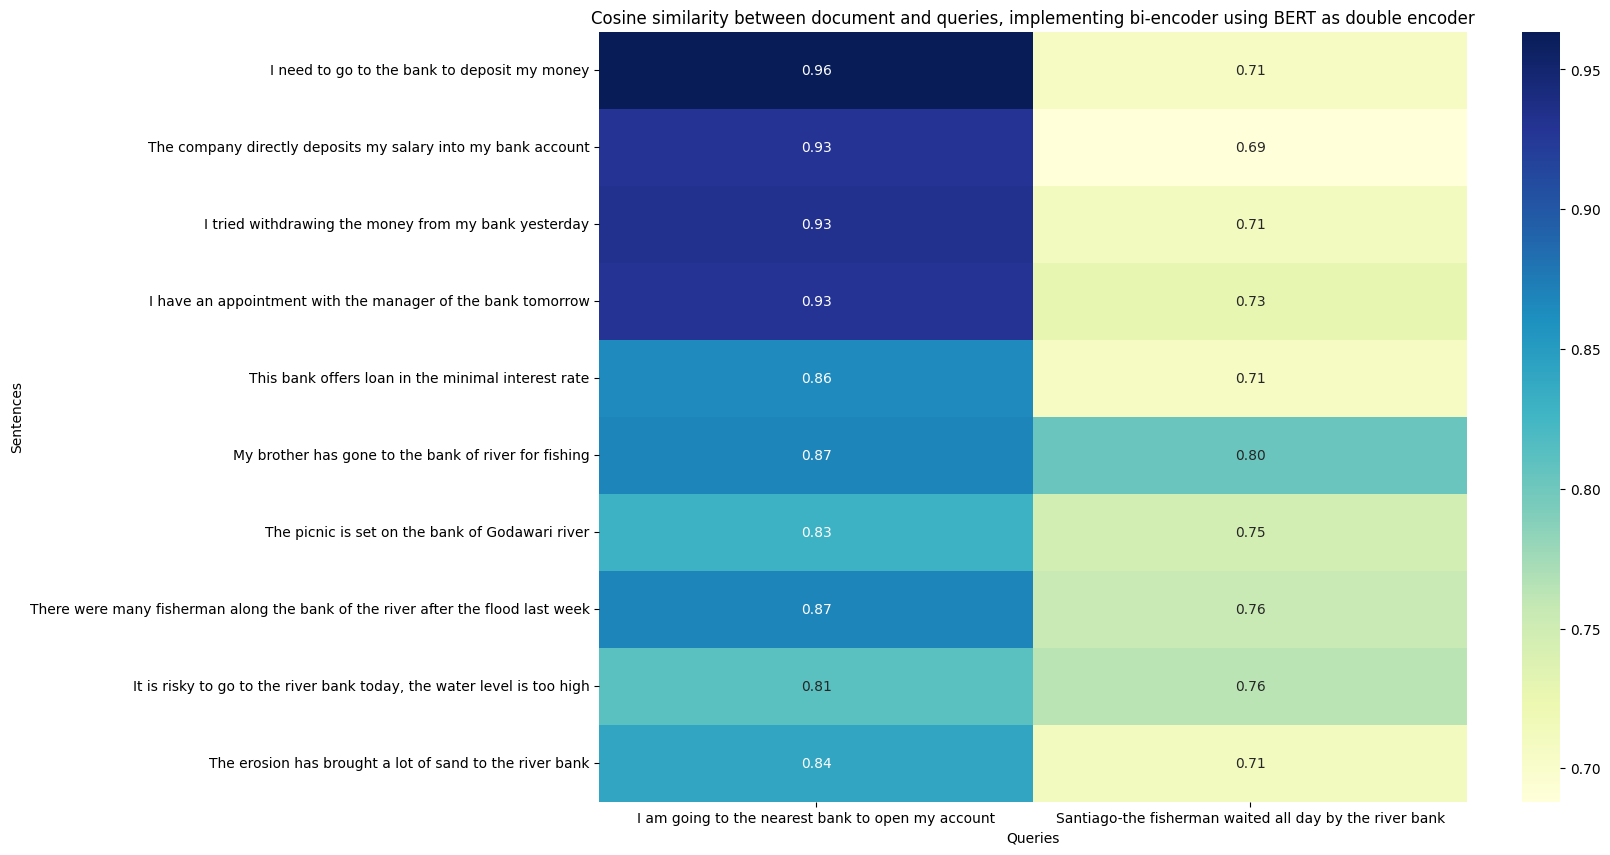

In [41]:
plt.figure(figsize=(14,10))
sns.heatmap(sorted_similarities, annot=True, fmt=".2f", cmap="YlGnBu", yticklabels=sorted_sentences, xticklabels=queries)
plt.title("Cosine similarity between document and queries, implementing bi-encoder using BERT as double encoder")
plt.xlabel("Queries")
plt.ylabel("Sentences")
plt.show()